# RAG From scratch: Retrieval


## Environment

`(1) Packages`

In [1]:
!pip install langchain_community langchain_openai langchainhub langchain -q
!pip install tiktoken chromadb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 20.3 MB/s eta 0:00:

`(2) LangSmith`

In [2]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"

In [ ]:
api_key = os.getenv("LANGCHAIN_API_KEY")
if api_key:
    os.environ["LANGCHAIN_API_KEY"] = api_key
else:
    api_key = input("Enter your API key: ")
    os.environ["LANGCHAIN_API_KEY"] = api_key

`(3) API Keys`

In [ ]:
api_key = os.getenv("OPENAI_API_KEY")
if api_key:
    os.environ["OPENAI_API_KEY"] = api_key
    api_key = input("Enter your API key: ")
    os.environ["OPENAI_API_KEY"] = api_key
else:
    api_key = input("Enter your API key: ")
    os.environ["OPENAI_API_KEY"] = api_key

## Re-ranking

Similar to RAG-fusion

### Indexing

In [5]:
# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    )
)

blog_docs = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300,
    chunk_overlap=50
)

# Make splits
splits = text_splitter.split_documents(blog_docs)

# Index
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
vectorstore = Chroma.from_documents(
    documents=splits,
    embedding=OpenAIEmbeddings()
)
retriever = vectorstore.as_retriever()

In [6]:
# RAG-Fusion
from langchain.prompts import ChatPromptTemplate

template = """
You are a helpful assistant that generates multiple search queries based
on single input query. \n
Generate multiple search queries related to: {question} \n
Output (4 queries):
"""
prompt_rag_fusion = ChatPromptTemplate.from_template(template)

In [7]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_rag_fusion
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

In [8]:
from langchain.load import dumps, loads


def reciprocal_rank_fusion(results: list[list], k=60):
    """
    Reciprocal rank fusion that takes multiple lists of ranked document
    and an optional parameter k used in the RRF formula
    """

    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = {}

    # Iterate through each list of ranked documents
    for docs in results:
        # Iterate through each document in the list, with its rank (position in the list)
        for rank, doc in enumerate(docs):
            # Convert the document to a string format to use as a key (assumes documents
            # can be serialized to JSON)
            doc_str = dumps(doc)
            # If the document is not yet in the fused_scores dictionary
            # add it with an initial score of 0
            if doc_str not in fused_scores:
                fused_scores[doc_str] = 0
            # Retrieve the current score of the document if any
            previous_score = fused_scores[doc_str]
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    # Sort the documents based on their fused scores in descending order
    # to get the final reranked results
    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]
    # Return the reranked results as a list of tuples, each containing the
    # document and its fused score
    return reranked_results


question = "What is task decomposition for LLM agents?"
retrieval_chain_rag_fusion = (
    generate_queries
    | retriever.map()
    | reciprocal_rank_fusion
)

docs = retrieval_chain_rag_fusion.invoke(
    {
        "question": question
    }
)
len(docs)

<ipython-input-8-e6cf685b3424>:32: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  (loads(doc), score)


7

In [9]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """
Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)
llm = ChatOpenAI(temperature=0)

final_rag_chain = (
    {
        "context": retrieval_chain_rag_fusion,
        "question": itemgetter("question")
    }
    | prompt
    | llm
    | StrOutputParser()
)

final_rag_chain.invoke(
    {
        "question": question
    }
)

'Task decomposition for LLM agents involves breaking down complex tasks into smaller and simpler steps to enhance model performance. This can be achieved through techniques like Chain of Thought (CoT) and Tree of Thoughts, which prompt the model to think step by step and explore multiple reasoning possibilities at each step. Task decomposition can be done through simple prompting, task-specific instructions, or with human inputs.'

In [10]:
!pip install -q cohere

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 65.6 MB/s eta 0:00:00


In [11]:
from langchain_community.llms import Cohere
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import CohereRerank

In [ ]:
api_key = os.getenv("COHERE_API_KEY")
if api_key:
    os.environ["COHERE_API_KEY"] = api_key
else:
    api_key = input("Enter your API key: ")
    os.environ["COHERE_API_KEY"] = api_key

In [13]:
retriever = vectorstore.as_retriever()

# Re-rank
compressor = CohereRerank()
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=retriever
)
compressed_docs = compression_retriever.get_relevant_documents(question)

<ipython-input-13-7cc7b9b1a792>:4: LangChainDeprecationWarning: The class `CohereRerank` was deprecated in LangChain 0.0.30 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-cohere package and should be used instead. To use it run `pip install -U :class:`~langchain-cohere` and import as `from :class:`~langchain_cohere import CohereRerank``.
  compressor = CohereRerank()
<ipython-input-13-7cc7b9b1a792>:9: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  compressed_docs = compression_retriever.get_relevant_documents(question)


In [14]:
dict(compressed_docs[0])

{'id': None,
 'metadata': {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
  'relevance_score': 0.9986541},
 'page_content': 'Fig. 1. Overview of a LLM-powered autonomous agent system.\nComponent One: Planning#\nA complicated task usually involves many steps. An agent needs to know what they are and plan ahead.\nTask Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation to decompose hard tasks into smaller and simpler steps. CoT transforms big tasks into multiple manageable tasks and shed lights into an interpretation of the model’s thinking process.\nTree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The sear

## Corrective RAG (CRAG) using local LLMs

Corrective-RAG (CRAG) is a strategy for RAG that incorporates self-reflection/self-grading on retrieved documents.

The paper follows this general flow:
- If at least one document exceeds the threshold for `relevance`, then it proceeds to generation
- If all documents fall below the `relevance` threshold or if the grader is unsure, then it uses web search to supplement retrieval
- Before generation, it performs knowledge refinement of the search or retrieved documents
- This partitions the document into `knowledge strips`
- It grades each strip, and filters out irrelevant ones

We will implement some of these ideas from scratch using LangGraph:

- If any documents are irrelevant, we'll supplement retrieval with web search.
- We'll skip the knowledge refinement, but this can be added back as a node if desired.
- We'll use `Tavily Search` for web search.

In [15]:
%%capture --no-stderr
!pip install -U -q langchain_community tiktoken langchainhub scikit-learn langchain langgraph tavily-python  nomic[local] langchain-nomic langchain_openai

In [ ]:
api_key = os.getenv("TAVILY_API_KEY")
if api_key:
    os.environ["TAVILY_API_KEY"] = api_key
else:
    api_key = input("Enter your API key: ")
    os.environ["TAVILY_API_KEY"] = api_key

### LLM

Before run this command you need to run in GPU Machine the follow commands in the terminal

- Download and extract the package
```
curl -L https://ollama.com/download/ollama-linux-amd64.tgz -o ollama-linux-amd64.tgz
sudo tar -C /usr -xzf ollama-linux-amd64.tgz
```

- Start Ollama:

```
ollama serve
```

After that you can run this command below

In [26]:
!ollama pull llama3.1

pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠼ pulling manifest ⠼ pulling manifest ⠴ pulling manifest 
pulling 667b0c1932bc...   0% ▕▏    0 B/4.9 GB                  pulling manifest 
pulling 667b0c1932bc...   0% ▕▏    0 B/4.9 GB                  pulling manifest 
pulling 667b0c1932bc...   0% ▕▏    0 B/4.9 GB                  pulling manifest 
pulling 667b0c1932bc...   0% ▕▏    0 B/4.9 GB                  pulling manifest 
pulling 667b0c1932bc...   1% ▕▏  29 MB/4.9 GB                  pulling manifest 
pulling 667b0c1932bc...   2% ▕▏  85 MB/4.9 GB                  pulling manifest 
pulling 667b0c1932bc...   2% ▕▏ 113 MB/4.9 GB                  pulling manifest 
pulling 667b0c1932bc...   3% ▕▏ 136 MB/4.9 GB                  pulling manifest 
pulling 667b0c1932bc...   3% ▕▏ 164 MB/4.9 GB                  pulling manifest 
pulling 667b0c1932bc...   4% ▕▏ 178 MB/4.9 GB                  pulling manifest 
pulling 667b0c1932bc...   4% ▕▏ 207 MB/4.9 GB  207 MB/s   

In [27]:
local_llm = "llama3.1"
model_tested = "llama3.1-8b"
metadata = f"CRAG, {model_tested}"

### Create Index

In [28]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings # local
from langchain_openai import OpenAIEmbeddings # api

# List of URLs to load documents from
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents from the URLs

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250,
    chunk_overlap=0
)

# Split the documents into chunks
splits = text_splitter.split_documents(docs_list)

# Embedding
embedding = OpenAIEmbeddings()

# Add the document chunks to the vector store
vectorstore = SKLearnVectorStore.from_documents(
    documents=splits,
    embedding=embedding
)
retriever = vectorstore.as_retriever(k=4)

### Define Tool

In [29]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser
# from langchain_mistralai.chat_models import ChatMistralAI

# LLM
llm = ChatOllama(model=local_llm, format="json", temperature=0)

# Prompt
prompt = PromptTemplate(
    template="""You are a teacher grading a quiz. You will be given:
    1/ a QUESTION
    2/ A FACT provided by the student

    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the statements in the FACT are relevant to the QUESTION.
    A score of 0 means that NONE of the statements in the FACT are relevant to the QUESTION.
    1 is the highest (best) score. 0 is the lowest score you can give.

    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct.

    Avoid simply stating the correct answer at the outset.

    Question: {question} \n
    Fact: \n\n {documents} \n\n

    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """,
    input_variables=["question", "documents"],
)

retrieval_grader = (
    prompt
    | llm
    | JsonOutputParser()
)
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
doc_txt

'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory'

In [30]:
llm

ChatOllama(model='llama3.1', temperature=0.0, format='json')

In [31]:

print(retrieval_grader.invoke({"question": question, "documents": doc_txt}))

{'score': '1'}


In [32]:
### Generate
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks.

    Use the following documents to answer the question.

    If you don't know the answer, just say that you don't know.

    Use three sentences maximum and keep the answer concise:
    Question: {question}
    Documents: {documents}
    Answer:
    """,
    input_variables=["question", "documents"],
)

# LLM
llm = ChatOllama(model=local_llm, temperature=0)

# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

It appears you provided a list of documents with metadata and content related to LLM-powered autonomous agents. However, there is no specific question or problem to solve.

If you'd like to ask a question or request assistance on a particular topic related to these documents, I'll do my best to help.


In [33]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

### Create the Graph

Here we'll explicitly define the majority of the control flow, only using an LLM to define a single branch point following grading.

In [35]:
from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
    - question: question
    - generation: LLM generation
    - search: whether to add search
    - documents: list of documents
    """

    question: str
    generation: str
    search: bool
    documents: List[str]
    steps: List[str]


def retrieve(state: dict):
    """
    Retrieve documents

    Parmeters:
    - state (dict): The current graph state

    Returns:
    - state (dict): New key added to state, documents, that contains retrieve
    documents
    """

    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("generate_documents")
    return {
        "documents": documents,
        "question": question,
        "steps": steps
    }


def generate(state):
    """
    Generate answer

    Parameters:
    - state (dict): The current graph state

    Returns:
    - state (dict): New key added to state, generation, that contains generated
    answer
    """
    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Parameters:
    - state (dict): The current graph state

    Returns:
    - state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Paremeters:
    - state (dict): The current graph state

    Returns:
    - state (dict): Updates documents key with appended web results
    """
    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {
        "documents": documents,
        "question": question,
        "steps": steps
    }


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Parameters:
    - state (dict): The current graph state

    Returns:
    - str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"

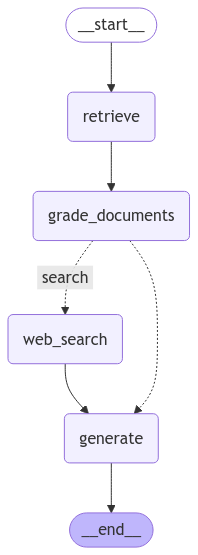

In [38]:
# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate", generate)
workflow.add_node("web_search", web_search)

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate"
    }
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

custom_graph = workflow.compile()

display(Image(custom_graph.get_graph(xray=True).draw_mermaid_png()))

In [39]:
import uuid

def predict_custom_agent_local_answer(example: dict):
    config = {
        "configurable": {
            "thread_id": str(uuid.uuid4())
        }
    }
    state_dict = custom_graph.invoke(
        {
            "question": example["input"],
            "steps": []
        },
        config
    )
    return {
        "response": state_dict["generation"],
        "steps": state_dict["steps"]
    }


example = {"input": "What are the types of agent memory?"}
response = predict_custom_agent_local_answer(example)
response

{'response': 'There are several types of agent memory mentioned in the documents. These include Mem0.ai\'s personalization and persistent memory stores, Zep\'s knowledge graph or memory store for retaining facts and metadata, and ConversationBufferWindowMemory which keeps recent exchanges but deletes oldest ones. Additionally, simple reflex agents do not require memory to react to environmental changes using "if-then" rules.',
 'steps': ['generate_documents',
  'grade_document_retrieval',
  'web_search',
  'generate_answer']}

### Evaluation

Now we've defined two different agent architectures that do roughly the same thing!



In [40]:
from langsmith import Client

client = Client()

# Create a dataset
examples = [
    (
        "How does the ReAct agent use self-reflection? ",
        "ReAct integrates reasoning and acting, performing actions - such tools like Wikipedia search API - and then observing / reasoning about the tool outputs.",
    ),
    (
        "What are the types of biases that can arise with few-shot prompting?",
        "The biases that can arise with few-shot prompting include (1) Majority label bias, (2) Recency bias, and (3) Common token bias.",
    ),
    (
        "What are five types of adversarial attacks?",
        "Five types of adversarial attacks are (1) Token manipulation, (2) Gradient based attack, (3) Jailbreak prompting, (4) Human red-teaming, (5) Model red-teaming.",
    ),
    (
        "Who did the Chicago Bears draft first in the 2024 NFL draft”?",
        "The Chicago Bears drafted Caleb Williams first in the 2024 NFL draft.",
    ),
    ("Who won the 2024 NBA finals?", "The Boston Celtics on the 2024 NBA finals"),
]

# Save it
dataset_name = "Corrective RAG Agent Testing"
if not client.has_dataset(dataset_name=dataset_name):
    dataset = client.create_dataset(dataset_name=dataset_name)
    inputs, outputs = zip(
        *[({"input": text}, {"output": label}) for text, label in examples]
    )
    client.create_examples(inputs=inputs, outputs=outputs, dataset_id=dataset.id)

Now we use an `LLM as a grader`.

In [41]:
from langchain import hub
from langchain_openai import ChatOpenAI

# Grade prompt
grade_prompt_answer_accuracy = hub.pull(
    "langchain-ai/rag-answer-vs-reference"
)


def answer_evaluator(run, example) -> dict:
    """
    A simple evaluator for RAG answer accuracy
    """

    # Get the question, the ground truth reference answer,
    # RAG chain answer prediction
    input_question = example.inputs["input"]
    reference = example.outputs["output"]
    prediction = run.outputs["response"]

    # Define an LLM grader
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
    answer_grader = grade_prompt_answer_accuracy | llm

    # Run evaluator
    score = answer_grader.invoke(
        {
            "question": input_question,
            "correct_answer": reference,
            "student_answer": prediction,
        }
    )
    score = score["Score"]
    return {
        "key": "answer_v_reference_score",
        "score": score
    }

In [42]:
from langsmith.schemas import Example, Run

# Reasoning traces that we expect the agents to take
expected_trajectory_1 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "web_search",
    "generate_answer",
]
expected_trajectory_2 = [
    "retrieve_documents",
    "grade_document_retrieval",
    "generate_answer",
]


### This evaluates the specifc reasoning traces taken by our agents

def find_tool_calls_react(messages):
    """
    Find all tool calls in the messages returned
    """
    tool_calls = [tc['name'] for m in messages['messages'] for tc in getattr(m, 'tool_calls', [])]
    return tool_calls


def check_trajectory_react(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    messages = root_run.outputs["messages"]
    tool_calls = find_tool_calls_react(messages)
    print(f"Tool calls ReAct agent: {tool_calls}")
    if tool_calls == expected_trajectory_1 or tool_calls == expected_trajectory_2:
        score = 1
    else:
        score = 0

    return {"score": int(score), "key": "tool_calls_in_exact_order"}


def check_trajectory_custom(root_run: Run, example: Example) -> dict:
    """
    Check if all expected tools are called in exact order and without any additional tool calls.
    """
    tool_calls = root_run.outputs["steps"]
    print(f"Tool calls custom agent: {tool_calls}")
    if tool_calls == expected_trajectory_1 or tool_calls == expected_trajectory_2:
        score = 1
    else:
        score = 0

    return {"score": int(score),
            "key": "tool_calls_in_exact_order"}

In [46]:
from langsmith.evaluation import evaluate

experiment_prefix = f"custom-agent-{model_tested}"
experiment_results = evaluate(
    predict_custom_agent_local_answer,
    data=dataset_name,
    evaluators=[answer_evaluator, check_trajectory_custom],
    experiment_prefix=experiment_prefix + "-answer-and-tool-use",
    num_repetitions=3,
    max_concurrency=2,
    metadata={
        "version": metadata
    }
)

View the evaluation results for experiment: 'custom-agent-llama3.1-8b-answer-and-tool-use-b80a7b6a' at:
https://smith.langchain.com/o/ae1b44aa-d87c-5ff6-b3da-d86792fddc91/datasets/1a76be9a-0587-493c-a018-8480aebe3ce8/compare?selectedSessions=1c1ed44d-3c6b-4a81-8a05-86ec3af0b2ee




0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/langchain_openai/chat_models/base.py:407: UserWarning: This model does not support OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. To use `with_structured_output` with this model, specify `method="function_calling"`.
  warnings.warn(message)
ERROR:langsmith.evaluation._runner:Error running evaluator <DynamicRunEvaluator answer_evaluator> on run b07c1d3d-d272-401e-854d-91ca1d674636: BadRequestError('Error code: 400 - {\'error\': {\'message\': "Invalid parameter: \'response_format\' of type \'json_schema\' is not supported with this model. Learn more about supported models at the Structured Outputs guide: https://platform.openai.com/docs/guides/structured-outputs", \'type\': \'invalid_request_error\', \'param\': None, \'code\': None}}')
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/langsmith/evaluation/_runner.py", line 1573, in _run_evalu

Tool calls custom agent: ['generate_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


/usr/local/lib/python3.10/dist-packages/langchain_openai/chat_models/base.py:407: UserWarning: This model does not support OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. To use `with_structured_output` with this model, specify `method="function_calling"`.
  warnings.warn(message)
ERROR:langsmith.evaluation._runner:Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 37633506-042b-4f09-ae87-9e5f5e5d4f2f: BadRequestError('Error code: 400 - {\'error\': {\'message\': "Invalid parameter: \'response_format\' of type \'json_schema\' is not supported with this model. Learn more about supported models at the Structured Outputs guide: https://platform.openai.com/docs/guides/structured-outputs", \'type\': \'invalid_request_error\', \'param\': None, \'code\': None}}')
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/langsmith/evaluation/_runner.py", line 1573, in _run_evalu

Tool calls custom agent: ['generate_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


/usr/local/lib/python3.10/dist-packages/langchain_openai/chat_models/base.py:407: UserWarning: This model does not support OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. To use `with_structured_output` with this model, specify `method="function_calling"`.
  warnings.warn(message)
ERROR:langsmith.evaluation._runner:Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 4f0e31df-79b8-4ee9-b0c2-ff3e0e5fa309: BadRequestError('Error code: 400 - {\'error\': {\'message\': "Invalid parameter: \'response_format\' of type \'json_schema\' is not supported with this model. Learn more about supported models at the Structured Outputs guide: https://platform.openai.com/docs/guides/structured-outputs", \'type\': \'invalid_request_error\', \'param\': None, \'code\': None}}')
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/langsmith/evaluation/_runner.py", line 1573, in _run_evalu

Tool calls custom agent: ['generate_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


/usr/local/lib/python3.10/dist-packages/langchain_openai/chat_models/base.py:407: UserWarning: This model does not support OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. To use `with_structured_output` with this model, specify `method="function_calling"`.
  warnings.warn(message)
ERROR:langsmith.evaluation._runner:Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 44fe329d-ce8e-4f83-8ea2-d07501266d80: BadRequestError('Error code: 400 - {\'error\': {\'message\': "Invalid parameter: \'response_format\' of type \'json_schema\' is not supported with this model. Learn more about supported models at the Structured Outputs guide: https://platform.openai.com/docs/guides/structured-outputs", \'type\': \'invalid_request_error\', \'param\': None, \'code\': None}}')
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/langsmith/evaluation/_runner.py", line 1573, in _run_evalu

Tool calls custom agent: ['generate_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


/usr/local/lib/python3.10/dist-packages/langchain_openai/chat_models/base.py:407: UserWarning: This model does not support OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. To use `with_structured_output` with this model, specify `method="function_calling"`.
  warnings.warn(message)
ERROR:langsmith.evaluation._runner:Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 082bee54-07b4-4eee-be15-10df904fa996: BadRequestError('Error code: 400 - {\'error\': {\'message\': "Invalid parameter: \'response_format\' of type \'json_schema\' is not supported with this model. Learn more about supported models at the Structured Outputs guide: https://platform.openai.com/docs/guides/structured-outputs", \'type\': \'invalid_request_error\', \'param\': None, \'code\': None}}')
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/langsmith/evaluation/_runner.py", line 1573, in _run_evalu

Tool calls custom agent: ['generate_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


/usr/local/lib/python3.10/dist-packages/langchain_openai/chat_models/base.py:407: UserWarning: This model does not support OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. To use `with_structured_output` with this model, specify `method="function_calling"`.
  warnings.warn(message)
ERROR:langsmith.evaluation._runner:Error running evaluator <DynamicRunEvaluator answer_evaluator> on run ef4afdd3-7012-4152-a5f0-1c512889e09a: BadRequestError('Error code: 400 - {\'error\': {\'message\': "Invalid parameter: \'response_format\' of type \'json_schema\' is not supported with this model. Learn more about supported models at the Structured Outputs guide: https://platform.openai.com/docs/guides/structured-outputs", \'type\': \'invalid_request_error\', \'param\': None, \'code\': None}}')
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/langsmith/evaluation/_runner.py", line 1573, in _run_evalu

Tool calls custom agent: ['generate_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


/usr/local/lib/python3.10/dist-packages/langchain_openai/chat_models/base.py:407: UserWarning: This model does not support OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. To use `with_structured_output` with this model, specify `method="function_calling"`.
  warnings.warn(message)
ERROR:langsmith.evaluation._runner:Error running evaluator <DynamicRunEvaluator answer_evaluator> on run ff62f190-4e20-4860-8008-9a4e318c3d81: BadRequestError('Error code: 400 - {\'error\': {\'message\': "Invalid parameter: \'response_format\' of type \'json_schema\' is not supported with this model. Learn more about supported models at the Structured Outputs guide: https://platform.openai.com/docs/guides/structured-outputs", \'type\': \'invalid_request_error\', \'param\': None, \'code\': None}}')
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/langsmith/evaluation/_runner.py", line 1573, in _run_evalu

Tool calls custom agent: ['generate_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


/usr/local/lib/python3.10/dist-packages/langchain_openai/chat_models/base.py:407: UserWarning: This model does not support OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. To use `with_structured_output` with this model, specify `method="function_calling"`.
  warnings.warn(message)
ERROR:langsmith.evaluation._runner:Error running evaluator <DynamicRunEvaluator answer_evaluator> on run f40c7756-00e6-4849-8f86-b7e67dac0855: BadRequestError('Error code: 400 - {\'error\': {\'message\': "Invalid parameter: \'response_format\' of type \'json_schema\' is not supported with this model. Learn more about supported models at the Structured Outputs guide: https://platform.openai.com/docs/guides/structured-outputs", \'type\': \'invalid_request_error\', \'param\': None, \'code\': None}}')
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/langsmith/evaluation/_runner.py", line 1573, in _run_evalu

Tool calls custom agent: ['generate_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


/usr/local/lib/python3.10/dist-packages/langchain_openai/chat_models/base.py:407: UserWarning: This model does not support OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. To use `with_structured_output` with this model, specify `method="function_calling"`.
  warnings.warn(message)
ERROR:langsmith.evaluation._runner:Error running evaluator <DynamicRunEvaluator answer_evaluator> on run e96f0a47-bc72-4bf7-a54f-210a9191d133: BadRequestError('Error code: 400 - {\'error\': {\'message\': "Invalid parameter: \'response_format\' of type \'json_schema\' is not supported with this model. Learn more about supported models at the Structured Outputs guide: https://platform.openai.com/docs/guides/structured-outputs", \'type\': \'invalid_request_error\', \'param\': None, \'code\': None}}')
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/langsmith/evaluation/_runner.py", line 1573, in _run_evalu

Tool calls custom agent: ['generate_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


/usr/local/lib/python3.10/dist-packages/langchain_openai/chat_models/base.py:407: UserWarning: This model does not support OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. To use `with_structured_output` with this model, specify `method="function_calling"`.
  warnings.warn(message)
ERROR:langsmith.evaluation._runner:Error running evaluator <DynamicRunEvaluator answer_evaluator> on run de7c617f-aa01-4cb4-aa98-65c2f1ec3b39: BadRequestError('Error code: 400 - {\'error\': {\'message\': "Invalid parameter: \'response_format\' of type \'json_schema\' is not supported with this model. Learn more about supported models at the Structured Outputs guide: https://platform.openai.com/docs/guides/structured-outputs", \'type\': \'invalid_request_error\', \'param\': None, \'code\': None}}')
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/langsmith/evaluation/_runner.py", line 1573, in _run_evalu

Tool calls custom agent: ['generate_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


/usr/local/lib/python3.10/dist-packages/langchain_openai/chat_models/base.py:407: UserWarning: This model does not support OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. To use `with_structured_output` with this model, specify `method="function_calling"`.
  warnings.warn(message)
ERROR:langsmith.evaluation._runner:Error running evaluator <DynamicRunEvaluator answer_evaluator> on run f1bd27ed-fe60-4fc9-baf6-175e68deae1c: BadRequestError('Error code: 400 - {\'error\': {\'message\': "Invalid parameter: \'response_format\' of type \'json_schema\' is not supported with this model. Learn more about supported models at the Structured Outputs guide: https://platform.openai.com/docs/guides/structured-outputs", \'type\': \'invalid_request_error\', \'param\': None, \'code\': None}}')
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/langsmith/evaluation/_runner.py", line 1573, in _run_evalu

Tool calls custom agent: ['generate_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['generate_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


/usr/local/lib/python3.10/dist-packages/langchain_openai/chat_models/base.py:407: UserWarning: This model does not support OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. To use `with_structured_output` with this model, specify `method="function_calling"`.
  warnings.warn(message)
ERROR:langsmith.evaluation._runner:Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 352abf41-f849-4c1e-b826-614f3de1c105: BadRequestError('Error code: 400 - {\'error\': {\'message\': "Invalid parameter: \'response_format\' of type \'json_schema\' is not supported with this model. Learn more about supported models at the Structured Outputs guide: https://platform.openai.com/docs/guides/structured-outputs", \'type\': \'invalid_request_error\', \'param\': None, \'code\': None}}')
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/langsmith/evaluation/_runner.py", line 1573, in _run_evalu

Tool calls custom agent: ['generate_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
Tool calls custom agent: ['generate_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']


/usr/local/lib/python3.10/dist-packages/langchain_openai/chat_models/base.py:407: UserWarning: This model does not support OpenAI's structured output feature, which is the default method for `with_structured_output` as of langchain-openai==0.3. To use `with_structured_output` with this model, specify `method="function_calling"`.
  warnings.warn(message)
ERROR:langsmith.evaluation._runner:Error running evaluator <DynamicRunEvaluator answer_evaluator> on run 41bebbe9-1985-40d3-85b3-ab795a801831: BadRequestError('Error code: 400 - {\'error\': {\'message\': "Invalid parameter: \'response_format\' of type \'json_schema\' is not supported with this model. Learn more about supported models at the Structured Outputs guide: https://platform.openai.com/docs/guides/structured-outputs", \'type\': \'invalid_request_error\', \'param\': None, \'code\': None}}')
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/langsmith/evaluation/_runner.py", line 1573, in _run_evalu

Tool calls custom agent: ['generate_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
